In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os.path import join
import seaborn as sns
from sys import path
path.insert(0,'../src/')
from glob import glob

from chemulator import Chemulator

# Initializing the Emulator

Chemulator has a simple initialization function that simple takes the path the directory where a chemical encoder is stored. In this case, we'll point it to the autoencoder from the Holdship et al. 2021 release paper.

The resulting emulator object can either be used to create a whole new emulator of the ```load_model``` function can be used to load a pre-trained model/ensemble. Here, we'll use the emulator used for the performance metrics of the release paper.

In [171]:
autoencoder_dir="../models/autoencoder-2021-release/"
emulator=Chemulator(autoencoder_dir=autoencoder_dir)
emulator.load_model("../models/emulator-2021-release/")

In [172]:
#import the actual dataset for the initial conditions of the predictions
#and for the benchmarking

data=pd.read_hdf("example_models.hdf",key="df").reset_index(drop=True)
data

,model,Time,gas_density,gas_temp,dust_temp,av,radfield,zeta,H,H+,...,MG+,CO+,CO,HCO+,O2,O2+,E-,coldens,h2col,ccol
0,6939,1000.0,2548.6,71.53,10.0,2.455700e-21,0.870462,2.253720,0.082356,1.691810e-08,...,0.000044,3.584520e-13,1.805500e-07,1.256760e-11,1.660070e-10,1.430850e-14,0.000274,3.904811e+00,5.069267e-08,1.109323e-07
1,6939,2000.0,2548.6,143.13,11.56,2.455700e-21,0.870462,2.253720,0.600815,2.050690e-07,...,0.000044,4.747840e-13,3.937840e-08,2.172240e-12,1.437690e-10,2.427510e-14,0.000315,3.904811e+00,5.069267e-08,1.109323e-07
2,6939,3000.0,2548.6,77.07,11.56,2.455700e-21,0.870462,2.253720,0.821727,2.591190e-07,...,0.000044,1.003860e-12,5.880830e-08,5.979380e-12,2.442260e-10,1.866310e-13,0.000322,3.904811e+00,5.069267e-08,1.109323e-07
3,6939,4000.0,2548.6,52.04,11.56,2.455700e-21,0.870462,2.253720,0.916669,5.381340e-07,...,0.000044,4.781420e-13,2.503280e-08,4.993680e-13,1.365850e-10,5.641730e-14,0.000317,3.904811e+00,5.069267e-08,1.109323e-07
4,6939,5000.0,2548.6,41.72,11.56,2.455700e-21,0.870462,2.253720,0.957926,7.702370e-07,...,0.000044,4.422410e-13,1.968780e-08,1.554400e-13,1.326230e-10,1.686190e-14,0.000313,3.904811e+00,5.069267e-08,1.109323e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9997,4951,996000.0,989240.0,100.00,15.02,1.818800e-04,3.222924,1.917344,0.044288,1.090620e-09,...,0.000008,3.464270e-15,3.740030e-05,1.879980e-12,1.153870e-10,1.765000e-15,0.000018,2.892011e+17,8.560156e+14,1.856038e+04
9998,4951,997000.0,989240.0,100.00,15.02,1.818800e-04,3.222924,1.917344,0.044271,1.084560e-09,...,0.000008,3.461970e-15,3.740030e-05,1.884360e-12,1.151710e-10,1.763940e-15,0.000018,2.892011e+17,8.560156e+14,1.856038e+04
9999,4951,998000.0,989240.0,99.95,15.02,1.818800e-04,3.222924,1.917344,0.044270,1.084390e-09,...,0.000008,3.461900e-15,3.740030e-05,1.884470e-12,1.151650e-10,1.763910e-15,0.000018,2.892011e+17,8.560156e+14,1.856038e+04
10000,4951,999000.0,989240.0,99.82,15.02,1.818800e-04,3.222924,1.917344,0.044274,1.085810e-09,...,0.000008,3.462430e-15,3.740030e-05,1.883440e-12,1.152150e-10,1.764160e-15,0.000018,2.892011e+17,8.560156e+14,1.856038e+04


In [173]:
# We set uo the starting time
t0=1000
tf=1e6
#Now the indexes where the models star at t0
index=data[(data["Time"]==t0)].index
steps=int((tf-t0)/1000.0)-1

In [174]:
steps

998

In [175]:
index

Int64Index([0, 1001, 2001, 3001, 4002, 5002, 6002, 7002, 8002, 9002], dtype='int64')

In [176]:
#Now lets prepare the different evaluations for each model
init_cond=[]
for i in index:
    init_cond.append(emulator.prepare_inputs(
        data.loc[i:i].reset_index(drop=True),learn_scaling=False)
    )

1/1 [==============================] - 0s 24ms/step


In [177]:
init_cond[0]

,gas_temp,gas_density,radfield,zeta,coldens,h2col,ccol,metallicity,Chem_1,Chem_2,Chem_3,Chem_4,Chem_5,Chem_6,Chem_7,Chem_8
0,0.26824,0.481258,0.156591,0.392139,0.0,0.0,0.0,0.818681,0.018243,0.18437,0.231199,0.313566,0.625941,0.046221,0.114786,0.414637


predictions=[]
for cond in init_cond:
    pred=pd.DataFrame() #The empty dataFrame to fill it up with the prediction o each model
    for step in range(steps):
        output = emulator.predict_multiple_timesteps(cond,1)
        pred=pred.append(output,sort=False) #esto evalua el modelo
        cond["gas_temp"]=output["gas_temp"]#estas dos, actualizan las condiciones por las actuales
        cond[emulator.chem_labels]=output[emulator.chem_labels]
    predictions.append(pred)

predictions[0]

#We save the model predictions for every model
n=0
for j in predictions:
    n=n+1
    j.to_csv(f'pred_model{str(n)}.csv')  

---

## Now lets plt every one of the evolutionsfor each model

In [178]:
model1=pd.read_csv('pred_model3.csv')
model1=model1.drop('Unnamed: 0',axis=1)
model1

,gas_temp,dust_temp,Chem_1,Chem_2,Chem_3,Chem_4,Chem_5,Chem_6,Chem_7,Chem_8
0,0.174833,0.083276,0.520434,0.197053,0.186746,0.349683,0.875661,0.061687,0.038430,0.092019
1,0.142563,0.063560,0.539852,0.235357,0.186853,0.381432,0.871682,0.065587,0.054049,0.092273
2,0.117226,0.048364,0.565977,0.278996,0.187060,0.403357,0.872922,0.069583,0.066203,0.091413
3,0.101608,0.039528,0.596360,0.311980,0.184715,0.421082,0.879756,0.070612,0.077098,0.091004
4,0.085645,0.033822,0.629950,0.327659,0.182693,0.434764,0.888392,0.069207,0.086735,0.091306
...,...,...,...,...,...,...,...,...,...,...
993,0.008413,0.026084,0.865134,0.281598,0.125343,0.510783,0.685897,0.017057,0.258989,0.071679
994,0.008413,0.026084,0.865134,0.281598,0.125343,0.510783,0.685897,0.017057,0.258989,0.071679
995,0.008413,0.026084,0.865134,0.281598,0.125343,0.510783,0.685897,0.017057,0.258989,0.071679
996,0.008413,0.026084,0.865134,0.281598,0.125343,0.510783,0.685897,0.017057,0.258989,0.071679


In [179]:
index

Int64Index([0, 1001, 2001, 3001, 4002, 5002, 6002, 7002, 8002, 9002], dtype='int64')

In [180]:
#get unscaled predictions
predicted=emulator.recover_real_values(model1)

i=index[2]
#grab the real data to compare
models=data.loc[i:i+998]

32/32 [==============================] - 0s 1ms/step


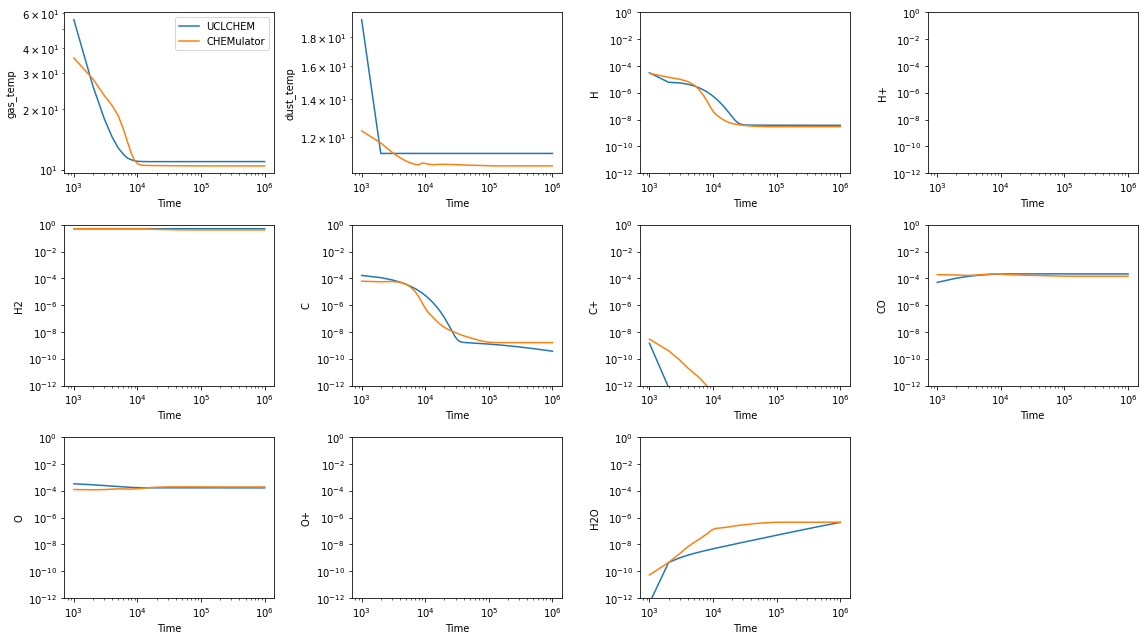

In [181]:
plot_specs=["gas_temp","dust_temp","H","H+","H2","C","C+","CO","O","O+","H2O"]
fig,axes=plt.subplots(3,4,tight_layout=True,figsize=(16,9))
times=[t0+(1000*i+1) for i in range(steps)]
axes=axes.flatten()
for i,ax in enumerate(axes[:-1]):
    ax.plot(models["Time"],models[plot_specs[i]],label="UCLCHEM")
    ax.plot(times,predicted[plot_specs[i]],label="CHEMulator")
    ax.set(xscale="log",yscale="log",xlabel="Time",ylabel=plot_specs[i])
    if i >1:
        ax.set(ylim=(1e-12,1))
axes[0].legend()
axes[-1].remove()

#### Just like that, for every model

For the benchmarking we need the mean o the predicted values for every model. And the standar deviation.

Then lets create an array as follows:

[ [ predicted values gas_temp], [predicted values dust_temp],...]

In [182]:
#Lets recover the true values, every element o this list are the predictions for that model
#true_vals[i] = predictions model i
predicted_vals=[]
for i in range(10):
    model=pd.read_csv(f'pred_model{str(i+1)}.csv')
    model=model.drop('Unnamed: 0',axis=1)
    predicted_vals.append(emulator.recover_real_values(model)[plot_specs])
#predicted_vals=np.array(predicted_vals) #[models,values,variable]

32/32 [==============================] - 0s 922us/step


In [183]:
real_vals=[]
for i in index:
    real_vals.append(data.loc[i+1:i+998][plot_specs])
#real_vals=np.array(real_vals)

In [184]:
#real_vals.shape
real=pd.concat(real_vals, axis=0)

In [185]:
#predicted_vals.shape
predicted=pd.concat(predicted_vals, axis=0)

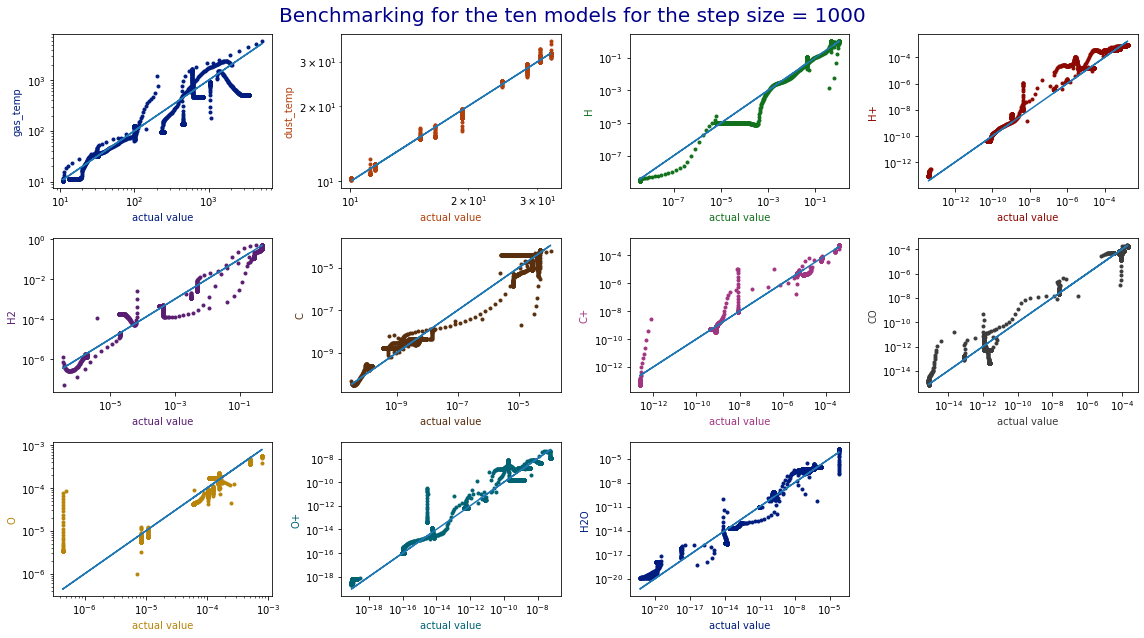

In [187]:
#fig,ax=plt.subplots(figsize=(25,12))
colors=sns.color_palette("dark",n_colors=11)
fig,axes=plt.subplots(3,4,tight_layout=True,figsize=(16,9))
axes=axes.flatten()

j=0
for i,ax in enumerate(axes[:-1]):
    ax.plot(real[plot_specs[j]],predicted[plot_specs[j]],'.', color=colors[i])
    ax.plot(real[plot_specs[j]],real[plot_specs[j]])
    
    #ax.plot(act_med[i],act_med[i],color='darkred')
    #ax.fill_between(np.log10(act_med[i]), np.log10(pred_med[i])-np.log10(real_sig[i]), 
    #                    np.log10(pred_medians[i])+np.log(pred_sig[i]))
    
    
    #ax.set(xscale="log",yscale="log",xlabel="actual value",ylabel=plot_specs[i])
    j=j+1
    ax.yaxis.label.set_color(colors[i])
    ax.xaxis.label.set_color(colors[i])
    ax.set(xscale="log",yscale="log",xlabel="actual value",ylabel=plot_specs[i])
fig.suptitle('Benchmarking for the ten models for the step size = 1000', fontsize=20, color='darkblue')
#ax.legend()

axes[-1].remove()

In [188]:
predicted=predicted.to_numpy()
real=real.to_numpy()

In [189]:
medianas_real=[]
medianas_pred=[]
std=[]
for spec in range(11):
    r=np.sort(real[:,spec])
    #p=predicted[:,spec]
    index=[]
    for i in r:
        index.append(np.where(real[:,spec]==i)[0][0])
    p=predicted[:,spec][index]
    #Ahora r esta ordenado en forma ascendente y p esta ordenado de la misma manera
    r_med=[]
    p_med=[]
    s=[]
    for k in range(499):
        r_med.append(np.median(r[k*20:(k+1)*20]))
        p_med.append(np.median(p[k*20:(k+1)*20]))
        s.append(np.std(p[k*20:(k+1)*20]))
        
    medianas_real.append(r_med)
    medianas_pred.append(p_med)
    std.append(s)
        

In [190]:
medianas_real=np.array(medianas_real)
medianas_pred=np.array(medianas_pred)
std=np.array(std)
        

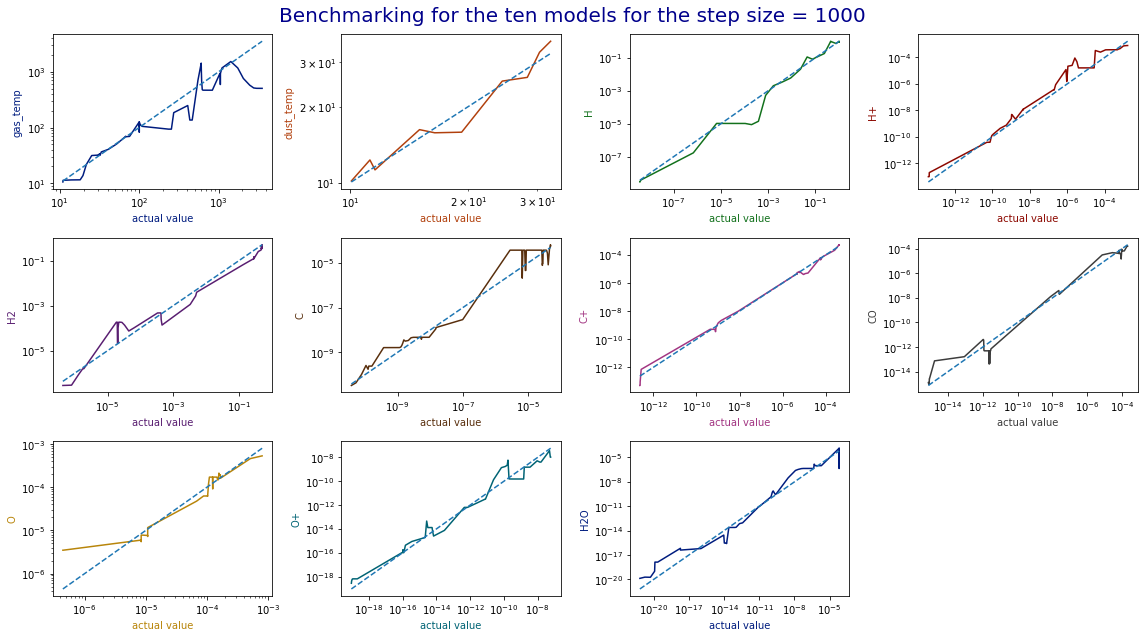

In [191]:
colors=sns.color_palette("dark",n_colors=11)
fig,axes=plt.subplots(3,4,tight_layout=True,figsize=(16,9))
axes=axes.flatten()

#j=0
for i,ax in enumerate(axes[:-1]):
    ax.plot(medianas_real[i],medianas_pred[i],'-', color=colors[i])
    ax.plot(medianas_real[i],medianas_real[i],'--')
    
    #ax.fill_between(medianas_real[i], medianas_pred[i]-std[i], medianas_pred[i]+std[i])
    
    ax.yaxis.label.set_color(colors[i])
    ax.xaxis.label.set_color(colors[i])
    ax.set(xscale="log",yscale="log",xlabel="actual value",ylabel=plot_specs[i])
fig.suptitle('Benchmarking for the ten models for the step size = 1000', fontsize=20, color='darkblue')
#ax.legend()

axes[-1].remove()

---
---
# Now we have to do the same, with steps of 100 and 1000
---
---

In [15]:
plot_specs=["gas_temp","dust_temp","H","H+","H2","C","C+","CO","O","O+","H2O"]

In [11]:
#now we make the predictions
data=pd.read_hdf("example_models.hdf",key="df").reset_index(drop=True)
# We set uo the starting time
t0=1000
tf=1e6
#Now the indexes where the models star at t0
index=data[(data["Time"]==t0)].index
steps=int((tf-t0)/100000.0)-1

#Now lets prepare the different evaluations for each model
init_cond=[]
for i in index:
    init_cond.append(emulator.prepare_inputs(
        data.loc[i:i].reset_index(drop=True),learn_scaling=False)
    )

1/1 [==============================] - 0s 25ms/step


###### Predictions for the step 100


In [12]:
predictions=[]
for cond in init_cond:
    pred=pd.DataFrame() #The empty dataFrame to fill it up with the prediction o each model
    for step in range(steps):
        output = emulator.predict_multiple_timesteps(cond,100)
        pred=pred.append(output,sort=False) #esto evalua el modelo
        cond["gas_temp"]=output["gas_temp"]#estas dos, actualizan las condiciones por las actuales
        cond[emulator.chem_labels]=output[emulator.chem_labels]
    predictions.append(pred)

1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_603833/59879064.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_603833/59879064.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_603833/59879064.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_603833/59879064.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_603833/59879064.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_603833/59879064.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_603833/59879064.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_603833/59879064.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_603833/59879064.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_603833/59879064.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_603833/59879064.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_603833/59879064.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_603833/59879064.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_603833/59879064.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_603833/59879064.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_603833/59879064.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - ETA: 0s

/var/tmp/rojasolvera/ipykernel_603833/59879064.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_603833/59879064.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_603833/59879064.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_603833/59879064.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_603833/59879064.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_603833/59879064.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_603833/59879064.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_603833/59879064.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_603833/59879064.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_603833/59879064.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_603833/59879064.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_603833/59879064.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - ETA: 0s

/var/tmp/rojasolvera/ipykernel_603833/59879064.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 28ms/step


/var/tmp/rojasolvera/ipykernel_603833/59879064.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_603833/59879064.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_603833/59879064.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_603833/59879064.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_603833/59879064.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_603833/59879064.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_603833/59879064.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_603833/59879064.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_603833/59879064.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_603833/59879064.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_603833/59879064.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_603833/59879064.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_603833/59879064.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_603833/59879064.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_603833/59879064.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_603833/59879064.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_603833/59879064.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_603833/59879064.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_603833/59879064.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_603833/59879064.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_603833/59879064.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_603833/59879064.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_603833/59879064.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_603833/59879064.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_603833/59879064.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_603833/59879064.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_603833/59879064.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_603833/59879064.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_603833/59879064.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_603833/59879064.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_603833/59879064.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_603833/59879064.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_603833/59879064.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_603833/59879064.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_603833/59879064.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_603833/59879064.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_603833/59879064.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_603833/59879064.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_603833/59879064.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_603833/59879064.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 29ms/step


/var/tmp/rojasolvera/ipykernel_603833/59879064.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_603833/59879064.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_603833/59879064.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_603833/59879064.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_603833/59879064.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


/var/tmp/rojasolvera/ipykernel_603833/59879064.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_603833/59879064.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_603833/59879064.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_603833/59879064.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_603833/59879064.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


/var/tmp/rojasolvera/ipykernel_603833/59879064.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


In [13]:
#We save the model predictions for every model
n=0
for j in predictions:
    n=n+1
    j.to_csv(f'pred_model{str(n)}_step100.csv')  

In [68]:
#Lets recover the true values, every element o this list are the predictions for that model
#true_vals[i] = predictions model i
predicted_vals=[]
for i in range(10):
    model=pd.read_csv(f'pred_model{str(i+1)}_step100.csv')
    model=model.drop('Unnamed: 0',axis=1)
    predicted_vals.append(emulator.recover_real_values(model)[plot_specs])
#predicted_vals=np.array(predicted_vals) #[models,values,variable]


1/1 [==============================] - 0s 27ms/step


In [69]:
predicted=pd.concat(predicted_vals, axis=0)

In [70]:
real_vals=[]
for i in index:
    v=[]
    for j in range(8):
        v.append(data.loc[round(i+1 + 124.75*j):round(i+1 + 124.75*j)][plot_specs])
        #v=pd.concat(v, axis=0)
    real_vals.append(pd.concat(v, axis=0))
#real_vals.append(data.loc[i+1:i+998][plot_specs])
#real_vals=np.array(real_vals)

In [71]:
real=pd.concat(real_vals,axis=0)

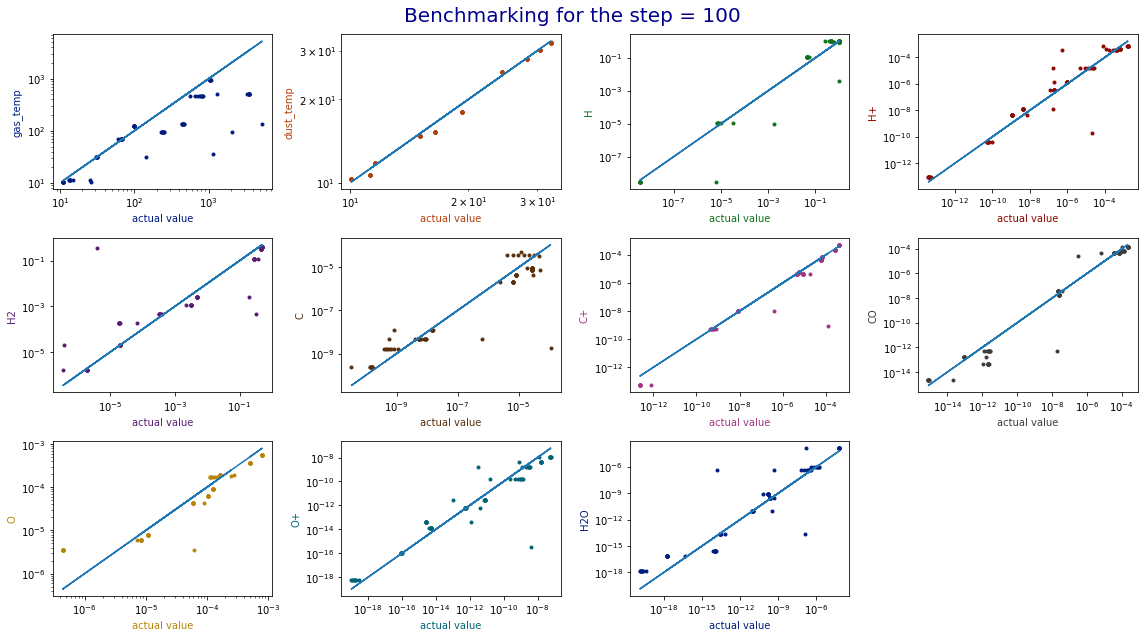

In [73]:
#fig,ax=plt.subplots(figsize=(25,12))
colors=sns.color_palette("dark",n_colors=11)
fig,axes=plt.subplots(3,4,tight_layout=True,figsize=(16,9))
axes=axes.flatten()

j=0
for i,ax in enumerate(axes[:-1]):
    ax.plot(real[plot_specs[j]],predicted[plot_specs[j]],'.', color=colors[i])
    ax.plot(real[plot_specs[j]],real[plot_specs[j]])
    
    #ax.plot(act_med[i],act_med[i],color='darkred')
    #ax.fill_between(np.log10(act_med[i]), np.log10(pred_med[i])-np.log10(real_sig[i]), 
    #                    np.log10(pred_medians[i])+np.log(pred_sig[i]))
    
    
    #ax.set(xscale="log",yscale="log",xlabel="actual value",ylabel=plot_specs[i])
    j=j+1
    ax.yaxis.label.set_color(colors[i])
    ax.xaxis.label.set_color(colors[i])
    ax.set(xscale="log",yscale="log",xlabel="actual value",ylabel=plot_specs[i])
fig.suptitle('Benchmarking for the step = 100', fontsize=20, color='darkblue')
#ax.legend()

axes[-1].remove()

In [74]:
predicted=predicted.to_numpy()
real=real.to_numpy()

In [77]:
len(real) #We can take the values of the median every 8 points, for 10 steps.

80

In [ ]:
for k in range(10):
    print(i)

In [128]:
medianas_real=[]
medianas_pred=[]
std=[]
for spec in range(11):
    r=np.sort(real[:,spec])
    #p=predicted[:,spec]
    index=[]
    for i in r:
        index.append(np.where(real[:,spec]==i)[0][0])
    p=predicted[:,spec][index]
    #Ahora r esta ordenado en forma ascendente y p esta ordenado de la misma manera
    r_med=[]
    p_med=[]
    s=[]
    for k in range(10):
        r_med.append(np.median(r[k*8:(k+1)*8]))
        p_med.append(np.median(p[k*8:(k+1)*8]))
        
        residual=np.sum((r[k*8:(k+1)*8]-p[k*8:(k+1)*8])**2)/6
        s.append(residual)
        
        #s.append(np.var(p[k*8:(k+1)*8]))
        
    medianas_real.append(r_med)
    medianas_pred.append(p_med)
    std.append(s)

In [129]:
medianas_real=np.log10(np.array(medianas_real))
medianas_pred=np.log10(np.array(medianas_pred))

#std=np.log10(np.array(std))
std=np.array(std)

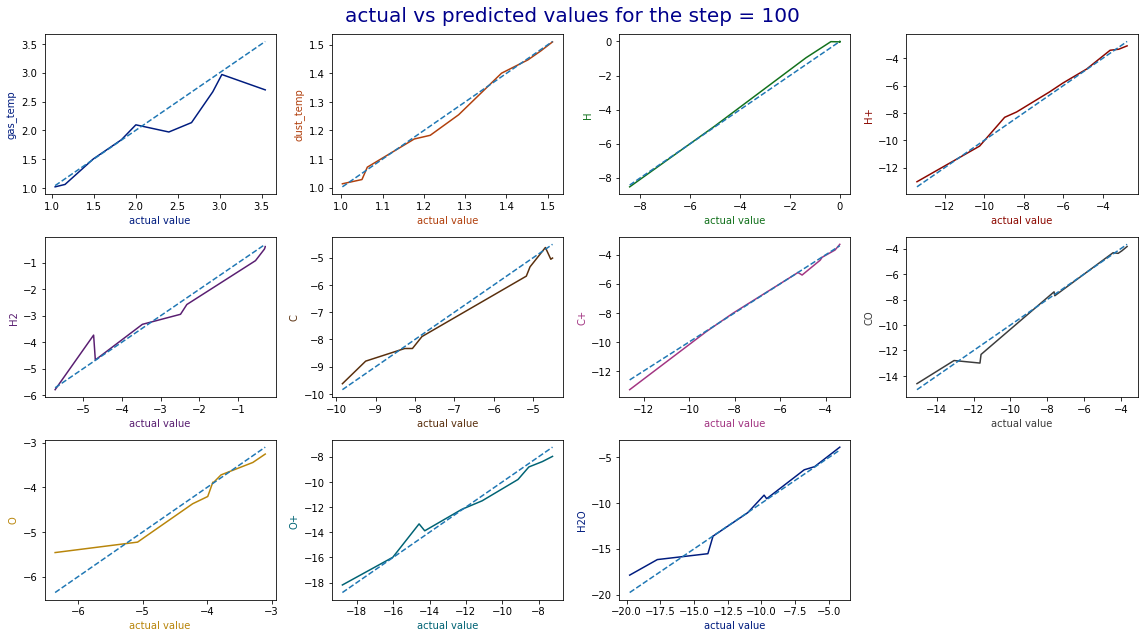

In [131]:
colors=sns.color_palette("dark",n_colors=11)
fig,axes=plt.subplots(3,4,tight_layout=True,figsize=(16,9))
axes=axes.flatten()

#j=0
for i,ax in enumerate(axes[:-1]):
    ax.plot(medianas_real[i],medianas_pred[i],'-', color=colors[i])
    ax.plot(medianas_real[i],medianas_real[i],'--')
    
    #ax.fill_between(medianas_real[i], medianas_pred[i]-std[i], medianas_pred[i]+std[i])
    
    ax.yaxis.label.set_color(colors[i])
    ax.xaxis.label.set_color(colors[i])
    ax.set(xlabel="actual value",ylabel=plot_specs[i])
fig.suptitle('actual vs predicted values for the step = 100', fontsize=20, color='darkblue')
#ax.legend()

axes[-1].remove()

---
---
# Now the step = 1
---
---
In this case, we have only 10 points 

In [314]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os.path import join
import seaborn as sns
from sys import path
path.insert(0,'../src/')
from glob import glob

from chemulator import Chemulator

In [315]:
autoencoder_dir="../models/autoencoder-2021-release/"
emulator=Chemulator(autoencoder_dir=autoencoder_dir)
emulator.load_model("../models/emulator-2021-release/")

In [316]:
plot_specs=["gas_temp","dust_temp","H","H+","H2","C","C+","CO","O","O+","H2O"]

In [317]:
#now we make the predictions
data=pd.read_hdf("example_models.hdf",key="df").reset_index(drop=True)
# We set uo the starting time
t0=1000
tf=1e6
#Now the indexes where the models star at t0
index=data[(data["Time"]==t0)].index
#steps=int((tf-t0)/100000.0)-1
steps=1
#Now lets prepare the different evaluations for each model
init_cond=[]
for i in index:
    init_cond.append(emulator.prepare_inputs(
        data.loc[i:i].reset_index(drop=True),learn_scaling=False)
    )

1/1 [==============================] - 0s 32ms/step


***Predictions for the single step***

In [318]:
predictions=[]
for cond in init_cond:
    pred=pd.DataFrame() #The empty dataFrame to fill it up with the prediction o each model
    for step in range(steps):
        output = emulator.predict_multiple_timesteps(cond,1000)
        pred=pred.append(output,sort=False) #esto evalua el modelo
        cond["gas_temp"]=output["gas_temp"]#estas dos, actualizan las condiciones por las actuales
        cond[emulator.chem_labels]=output[emulator.chem_labels]
    predictions.append(pred)

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 31ms/step


/var/tmp/rojasolvera/ipykernel_603833/2445517229.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 27ms/step


/var/tmp/rojasolvera/ipykernel_603833/2445517229.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_603833/2445517229.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 34ms/step


/var/tmp/rojasolvera/ipykernel_603833/2445517229.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 25ms/step


/var/tmp/rojasolvera/ipykernel_603833/2445517229.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 72ms/step


/var/tmp/rojasolvera/ipykernel_603833/2445517229.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 27ms/step


/var/tmp/rojasolvera/ipykernel_603833/2445517229.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_603833/2445517229.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 24ms/step


/var/tmp/rojasolvera/ipykernel_603833/2445517229.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 23ms/step


/var/tmp/rojasolvera/ipykernel_603833/2445517229.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(output,sort=False) #esto evalua el modelo


In [319]:
#We save the model predictions for every model
n=0
for j in predictions:
    n=n+1
    j.to_csv(f'pred_model{str(n)}_single_step.csv')

In [320]:
#Lets recover the true values, every element o this list are the predictions for that model
#true_vals[i] = predictions model i
predicted_vals=[]
for i in range(10):
    #model=pd.read_csv(f'pred_model{str(i+1)}_step100.csv')
    model=pd.read_csv(f'pred_model{str(i+1)}_single_step.csv')
    model=model.drop('Unnamed: 0',axis=1)
    predicted_vals.append(emulator.recover_real_values(model)[plot_specs])
#predicted_vals=np.array(predicted_vals) #[models,values,variable]

1/1 [==============================] - 0s 27ms/step


In [321]:
predicted=pd.concat(predicted_vals, axis=0)

In [322]:
predicted

,gas_temp,dust_temp,H,H+,H2,C,C+,CO,O,O+,H2O
0,31.900107,11.791091,9.471598e-01,1.524493e-06,0.002644,9.650621e-06,2.150269e-04,4.015192e-08,0.000362,6.462662e-13,3.057731e-10
0,68.516905,25.141682,9.659716e-01,3.425465e-07,0.001128,7.783489e-06,5.315428e-04,1.965169e-08,0.000558,3.131541e-12,9.153998e-12
0,10.430429,10.668173,2.952462e-09,9.542914e-14,0.410151,1.606900e-09,5.071131e-14,1.443536e-04,0.000191,6.483159e-19,4.494440e-07
0,504.939790,17.990391,9.610714e-01,8.052655e-04,0.000184,4.665207e-09,6.113181e-06,4.254692e-14,0.000008,4.087859e-09,2.947306e-16
0,93.615007,27.972498,1.000000e+00,1.633444e-05,0.000002,2.387299e-10,4.280040e-05,2.496065e-15,0.000063,1.554604e-10,1.328669e-18
0,11.484262,31.979867,1.038130e-05,3.825518e-11,0.403492,3.736885e-05,5.084981e-10,6.696217e-05,0.000171,1.028601e-16,9.824307e-07
0,467.761825,10.311434,9.983939e-01,3.849036e-04,0.000471,4.662882e-09,4.680959e-06,4.898999e-13,0.000006,1.530857e-09,2.447380e-14
0,136.329487,30.094704,9.245227e-01,4.555429e-04,0.000021,1.279528e-08,6.749674e-05,1.629890e-13,0.000091,1.056078e-08,6.687268e-17
0,933.125939,15.243498,9.772238e-01,1.188747e-08,0.120451,2.095636e-06,9.649922e-09,4.181317e-05,0.000003,4.597920e-14,1.349754e-04
0,124.706918,14.794808,1.112268e-01,4.845696e-09,0.331982,4.590777e-06,4.051283e-06,4.723345e-05,0.000043,1.301199e-14,7.528608e-10


In [323]:
real_vals=[]
for i in index:
    #v=[]
    #for j in range(8):
        #v.append(data.loc[round(i+1 + 124.75*j):round(i+1 + 124.75*j)][plot_specs])
        #v=pd.concat(v, axis=0)
    #real_vals.append(pd.concat(v, axis=0))
    real_vals.append(data.loc[i+998:i+998][plot_specs])
#real_vals=np.array(real_vals)

In [324]:
real=pd.concat(real_vals,axis=0)

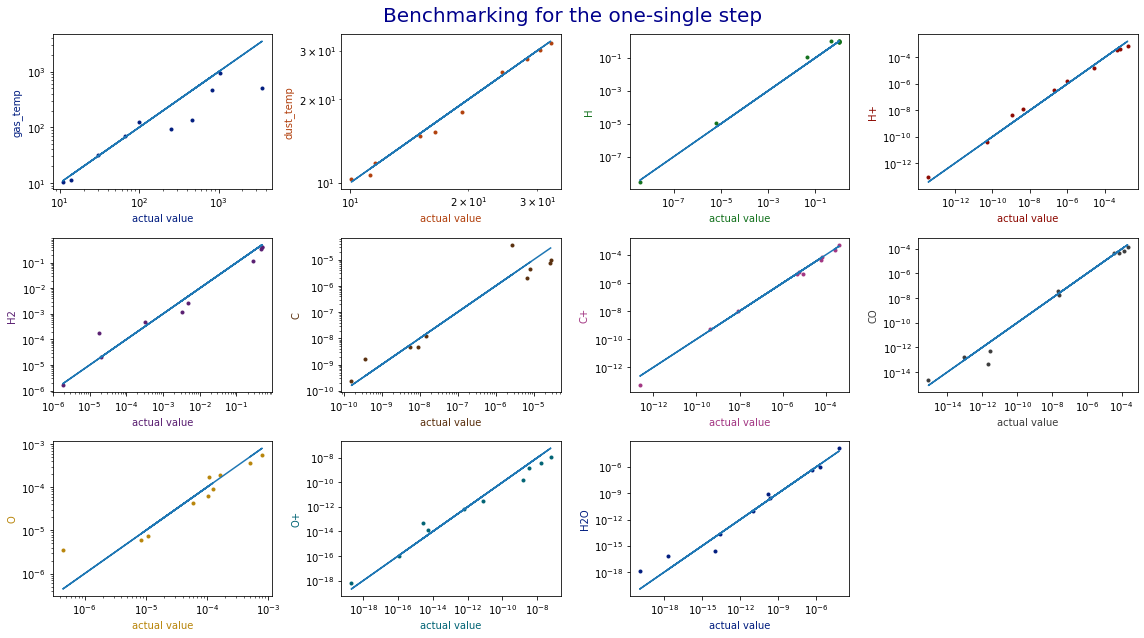

In [325]:
#fig,ax=plt.subplots(figsize=(25,12))
colors=sns.color_palette("dark",n_colors=11)
fig,axes=plt.subplots(3,4,tight_layout=True,figsize=(16,9))
axes=axes.flatten()

j=0
for i,ax in enumerate(axes[:-1]):
    ax.plot(real[plot_specs[j]],predicted[plot_specs[j]],'.', color=colors[i])
    ax.plot(real[plot_specs[j]],real[plot_specs[j]])
    
    #ax.plot(act_med[i],act_med[i],color='darkred')
    #ax.fill_between(np.log10(act_med[i]), np.log10(pred_med[i])-np.log10(real_sig[i]), 
    #                    np.log10(pred_medians[i])+np.log(pred_sig[i]))
    
    
    #ax.set(xscale="log",yscale="log",xlabel="actual value",ylabel=plot_specs[i])
    j=j+1
    ax.yaxis.label.set_color(colors[i])
    ax.xaxis.label.set_color(colors[i])
    ax.set(xscale="log",yscale="log",xlabel="actual value",ylabel=plot_specs[i])
fig.suptitle('Benchmarking for the one-single step', fontsize=20, color='darkblue')
#ax.legend()

axes[-1].remove()

---

In [326]:
predicted=predicted.to_numpy()
real=real.to_numpy()

In [327]:
medianas_real=[]
medianas_pred=[]
std=[]
for spec in range(11):
    r=np.sort(real[:,spec])
    #p=predicted[:,spec]
    index=[]
    for i in r:
        index.append(np.where(real[:,spec]==i)[0][0])
    p=predicted[:,spec][index]
    #Ahora r esta ordenado en forma ascendente y p esta ordenado de la misma manera
    r_med=[]
    p_med=[]
    s=[]
    for k in range(10):
        r_med.append(np.median(r[k:(k+1)]))
        #print('valor real =',r[k:(k+1)] )
        #print('mediana =', np.median(r[k:(k+1)]))
        
        p_med.append(np.median(p[k:(k+1)]))
        
        residual=np.sum((r[k:(k+1)]-p[k:(k+1)])**2)
        s.append(residual)
        
        #s.append(np.var(p[k*8:(k+1)*8]))
        
    medianas_real.append(r_med)
    medianas_pred.append(p_med)
    std.append(s)

medianas_real=r
medianas_pred=p

In [328]:
medianas_real=np.log10(np.array(medianas_real))
medianas_pred=np.log10(np.array(medianas_pred))

#std=np.log10(np.array(std))
std=np.array(std)

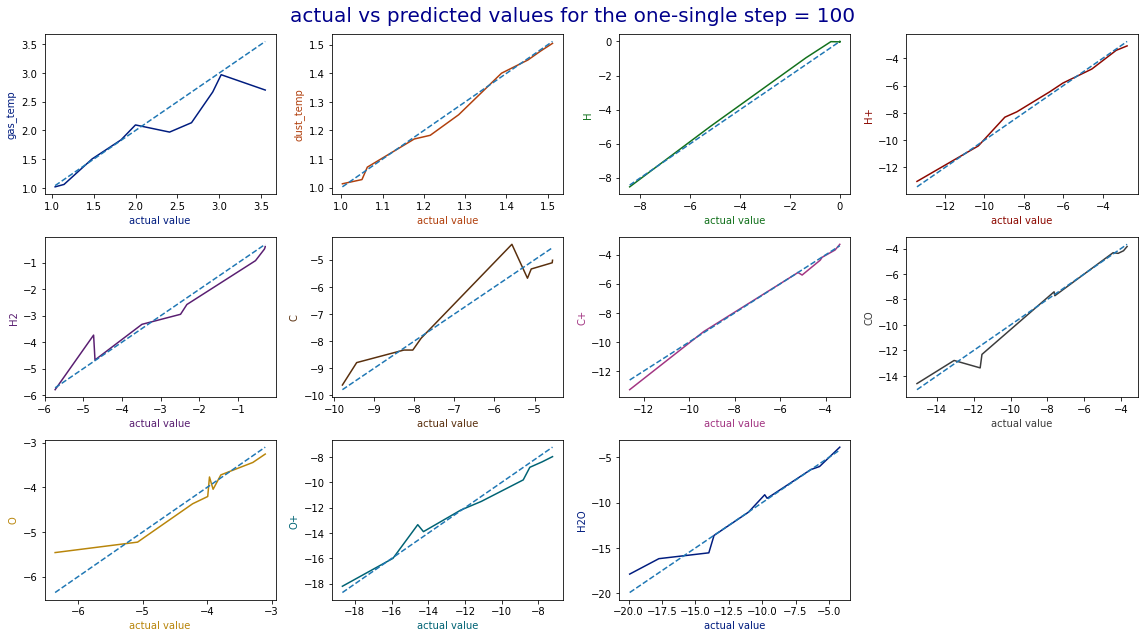

In [329]:
colors=sns.color_palette("dark",n_colors=11)
fig,axes=plt.subplots(3,4,tight_layout=True,figsize=(16,9))
axes=axes.flatten()

#j=0
for i,ax in enumerate(axes[:-1]):
    ax.plot(medianas_real[i],medianas_pred[i],'-', color=colors[i])
    ax.plot(medianas_real[i],medianas_real[i],'--')
    
    #ax.fill_between(medianas_real[i], medianas_pred[i]-std[i], medianas_pred[i]+std[i])
    
    ax.yaxis.label.set_color(colors[i])
    ax.xaxis.label.set_color(colors[i])
    ax.set(xlabel="actual value",ylabel=plot_specs[i])
fig.suptitle('actual vs predicted values for the one-single step = 100', fontsize=20, color='darkblue')
#ax.legend()

axes[-1].remove()

# Benchmarking vs UCLPDR

In [320]:
#this is a file with all the input column densities and the total UV
model_df=pd.read_csv("sine_input.csv")

#We're subsampling UCLPDR output so cut that down
particles=model_df["Particle"]
model_df

,Particle,T_g,n_H,H2_abun,C_abun,FUV,x,delta_x,delta_h2_col,delta_c_col,delta_col_dens,total_h2_col,total_c_col,total_col_dens,size
0,1,100.9120,52570.5,0.006470,1.676530e-06,9.99984,-3.180156e+19,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,16,102.7800,75087.7,0.050528,2.396100e-06,9.99984,-3.180156e+19,2.000000e+10,7.588078e+13,3.598353e+09,1.501754e+15,4.358194e+14,4.665551e+10,2.376777e+16,3.900000e+11
2,31,86.2791,92354.0,0.328082,3.635100e-06,9.99984,-3.180156e+19,9.999999e+09,3.029968e+14,3.357160e+09,9.235399e+14,4.352329e+15,1.061395e+11,4.331426e+16,6.200000e+11
3,46,74.5608,100606.0,0.421634,4.406570e-06,9.99984,-3.180156e+19,9.999999e+09,4.241891e+14,4.433273e+09,1.006060e+15,1.352157e+16,2.024797e+11,6.671263e+16,8.600000e+11
4,61,71.0860,98044.0,0.439261,4.455190e-06,9.99984,-3.180156e+19,2.000000e+10,8.613380e+14,8.736092e+09,1.960880e+15,2.393420e+16,3.103052e+11,9.075010e+16,1.100000e+12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,1381,16.8962,22895.8,0.499970,8.677700e-09,9.99984,3.180156e+19,2.000000e+10,2.289443e+14,3.973658e+06,4.579160e+14,1.026692e+24,3.592001e+17,2.053494e+24,6.360312e+19
93,1396,16.5534,44733.3,0.499982,3.891400e-09,9.99984,3.180156e+19,2.000000e+10,4.473169e+14,3.481504e+06,8.946661e+14,1.026692e+24,3.592001e+17,2.053494e+24,6.360312e+19
94,1411,14.7481,67936.9,0.499986,2.323510e-09,9.99984,3.180156e+19,2.000000e+10,6.793500e+14,3.157042e+06,1.358738e+15,1.026692e+24,3.592001e+17,2.053494e+24,6.360312e+19
95,1426,13.8569,87448.4,0.499988,1.709610e-09,9.99984,3.180156e+19,9.999999e+09,4.372315e+14,1.495026e+06,8.744839e+14,1.026692e+24,3.592001e+17,2.053494e+24,6.360312e+19


#### $\texttt{model_df}$ will be the inputs of the model, and particles is the array made up from the kind of particles used here. uclpdr contains the evolution of every particle (from 0 to 1462), then lets sampling the particles from the full uclpdr


In [321]:
uclpdr=pd.read_csv("sine_output.csv")
idx=uclpdr["Particle"].isin(particles)
uclpdr=uclpdr.loc[idx].reset_index(drop=True)

In [322]:
uclpdr

,Particle,n_H,n_g,T_g,T_d,FUV,F_x,Av,H3+_abun,He+_abun,...,"n(o-H2,15)_pop","n(o-H2,16)_pop","n(o-H2,17)_pop","n(o-H2,18)_pop","n(o-H2,19)_pop","n(o-H2,20)_pop","n(o-H2,21)_pop","n(o-H2,22)_pop","n(o-H2,23)_pop","n(o-H2,24)_pop"
0,1,52570.5,1.051410e-07,100.9120,20.9745,10.00000,0.0,0.000000,8.374400e-15,1.020870e-08,...,5.984800e-17,2.609020e-15,3.176370e-21,3.953920e-22,2.344590e-18,2.206570e-15,2.710510e-20,4.839880e-16,2.456730e-22,4.496400e-14
1,16,75087.7,1.501750e-07,102.7800,20.9743,9.99955,0.0,0.000015,3.371460e-13,5.735650e-09,...,0.000000e+00,3.552710e-14,4.607860e-19,3.970470e-22,1.962410e-17,0.000000e+00,0.000000e+00,6.605830e-15,0.000000e+00,5.506710e-13
2,31,92354.0,1.847080e-07,86.2791,20.9742,9.99919,0.0,0.000027,8.096680e-12,2.191460e-09,...,2.214890e-14,6.714630e-13,7.453890e-18,2.562270e-20,0.000000e+00,0.000000e+00,1.019150e-17,6.239450e-14,5.493000e-25,1.847410e-13
3,46,100606.0,2.012110e-07,74.5608,20.9740,9.99874,0.0,0.000042,1.090440e-11,1.774270e-09,...,1.038060e-14,0.000000e+00,0.000000e+00,2.541100e-21,1.925540e-16,2.611240e-13,0.000000e+00,6.328270e-14,1.113240e-26,1.278980e-13
4,61,98044.0,1.960880e-07,71.0860,20.9738,9.99829,0.0,0.000057,1.179950e-11,1.797420e-09,...,0.000000e+00,0.000000e+00,7.074420e-18,2.964620e-21,3.027090e-16,0.000000e+00,6.017320e-18,2.642330e-14,3.811780e-27,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,1381,22895.8,4.579170e-08,16.8962,10.0000,0.00000,0.0,1298.830000,1.984620e-09,5.237500e-10,...,1.778770e-18,0.000000e+00,5.459390e-22,4.771030e-27,0.000000e+00,5.589060e-17,4.400860e-24,2.238880e-17,1.604370e-59,2.775560e-16
93,1396,44733.3,8.946670e-08,16.5534,10.0000,0.00000,0.0,1298.830000,1.143490e-09,2.634240e-10,...,0.000000e+00,0.000000e+00,1.756930e-21,0.000000e+00,0.000000e+00,0.000000e+00,7.935760e-24,1.664250e-17,3.313760e-59,4.440890e-16
94,1411,67936.9,1.358740e-07,14.7481,10.0000,0.00000,0.0,1298.830000,8.057020e-10,1.721080e-10,...,7.216720e-19,0.000000e+00,0.000000e+00,1.186450e-26,6.352750e-22,0.000000e+00,9.512580e-24,0.000000e+00,0.000000e+00,0.000000e+00
95,1426,87448.4,1.748970e-07,13.8569,10.0000,0.00000,0.0,1298.830000,6.497690e-10,1.331480e-10,...,0.000000e+00,8.673620e-18,4.764560e-22,8.633290e-27,0.000000e+00,0.000000e+00,2.998530e-24,6.830470e-18,8.828900e-60,5.811320e-17


### Now we add the rest of the variables. This is, the inputs needed for the emulator

In [144]:
#then fill in other physics
model_df["zeta"]=3.84
model_df["metallicity"]=1.0
model_df=model_df[['T_g', 'n_H',"FUV","zeta",'total_col_dens','total_h2_col','total_c_col' ]]
model_df.columns=['gas_temp','gas_density','radfield','zeta','coldens','h2col','ccol']
model_df["radfield"]=1.7*model_df["radfield"] #UCLPDR in Draine, our code in Habing

/var/tmp/rojasolvera/ipykernel_3467/383046222.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df["radfield"]=1.7*model_df["radfield"] #UCLPDR in Draine, our code in Habing


In [145]:
init_cond[0]

,gas_temp,gas_density,radfield,zeta,coldens,h2col,ccol,metallicity,Chem_1,Chem_2,Chem_3,Chem_4,Chem_5,Chem_6,Chem_7,Chem_8
0,0.26824,0.481258,0.156591,0.392139,0.0,0.0,0.0,0.818681,0.018243,0.18437,0.231199,0.313566,0.625941,0.046221,0.114786,0.414637


In [146]:
model_df

,gas_temp,gas_density,radfield,zeta,coldens,h2col,ccol
0,100.9120,52570.5,16.999728,3.84,0.000000e+00,0.000000e+00,0.000000e+00
1,102.7800,75087.7,16.999728,3.84,2.376777e+16,4.358194e+14,4.665551e+10
2,86.2791,92354.0,16.999728,3.84,4.331426e+16,4.352329e+15,1.061395e+11
3,74.5608,100606.0,16.999728,3.84,6.671263e+16,1.352157e+16,2.024797e+11
4,71.0860,98044.0,16.999728,3.84,9.075010e+16,2.393420e+16,3.103052e+11
...,...,...,...,...,...,...,...
92,16.8962,22895.8,16.999728,3.84,2.053494e+24,1.026692e+24,3.592001e+17
93,16.5534,44733.3,16.999728,3.84,2.053494e+24,1.026692e+24,3.592001e+17
94,14.7481,67936.9,16.999728,3.84,2.053494e+24,1.026692e+24,3.592001e+17
95,13.8569,87448.4,16.999728,3.84,2.053494e+24,1.026692e+24,3.592001e+17


In [147]:
#we can add chemistry by setting all the species the autoencoder expects to 0
#Aqui se esta rellenando con la quimica, porque esta base de datos no tenia esas columnas de inicio
#Se estan llenando con puros ceros, para luego poner los valores que queremos
for spec in emulator.autoencoder.species:
    model_df[spec]=0.0

#aqui se ponen los valores que queremos, utilizando un loop
initial_abunds={
    "H":0.4,
    "H2":0.3,
    "HE":0.1,
    "C+":1.0e-4,
    "O":3.0e-4,
    "MG":5.00e-06,
    "E-":1.0e-4
}

for spec,abund in initial_abunds.items():
    model_df[spec]=abund
model_df=emulator.prepare_inputs(model_df,learn_scaling=False) #Luego se hace el encoding para que puedan ser ingresadas al emulador
model_df[model_df<0]=0.0 #se desprecian las abundancias negativas y ahora 

4/4 [==============================] - 0s 2ms/step


/var/tmp/rojasolvera/ipykernel_3467/3832802032.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df[spec]=0.0
/var/tmp/rojasolvera/ipykernel_3467/3832802032.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df[spec]=0.0
/var/tmp/rojasolvera/ipykernel_3467/3832802032.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

Asi que el resultado es un total de 96 condiciones iniciales que corresponden a 96 diferentes especies y que ahora se puede hacer la prediccion de su evolucion:

In [148]:
model_df 

,gas_temp,gas_density,radfield,zeta,coldens,h2col,ccol,metallicity,Chem_1,Chem_2,Chem_3,Chem_4,Chem_5,Chem_6,Chem_7,Chem_8
0,0.314680,0.744173,0.371728,0.430715,0.000000,0.000000,0.000000,0.634024,0.292424,0.117725,0.201037,0.001036,0.428459,0.044759,0.664875,0.038756
1,0.317155,0.775141,0.371728,0.430715,0.152853,0.513949,0.526609,0.634024,0.292424,0.117725,0.201037,0.001036,0.428459,0.044759,0.664875,0.038756
2,0.293539,0.793120,0.371728,0.430715,0.181816,0.567570,0.544367,0.634024,0.292424,0.117725,0.201037,0.001036,0.428459,0.044759,0.664875,0.038756
3,0.273840,0.800555,0.371728,0.430715,0.202660,0.593983,0.558321,0.634024,0.292424,0.117725,0.201037,0.001036,0.428459,0.044759,0.664875,0.038756
4,0.267400,0.798314,0.371728,0.430715,0.217510,0.607289,0.567544,0.634024,0.292424,0.117725,0.201037,0.001036,0.428459,0.044759,0.664875,0.038756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,0.073507,0.671968,0.371728,0.430715,1.000000,1.000000,0.869179,0.634024,0.292424,0.117725,0.201037,0.001036,0.428459,0.044759,0.664875,0.038756
93,0.070741,0.730149,0.371728,0.430715,1.000000,1.000000,0.869179,0.634024,0.292424,0.117725,0.201037,0.001036,0.428459,0.044759,0.664875,0.038756
94,0.055157,0.766448,0.371728,0.430715,1.000000,1.000000,0.869179,0.634024,0.292424,0.117725,0.201037,0.001036,0.428459,0.044759,0.664875,0.038756
95,0.046746,0.788379,0.371728,0.430715,1.000000,1.000000,0.869179,0.634024,0.292424,0.117725,0.201037,0.001036,0.428459,0.044759,0.664875,0.038756


Ahora el paso de tiempo que se esta evaluando es de #=1000, esto siginifica que las 
predicciones seran para 1e+6 yrs.

In [149]:
output=emulator.predict_multiple_timesteps(model_df,1000)
output=emulator.recover_real_values(output)

4/4 [==============================] - 0s 3ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 1ms/step


In [150]:
len(output) #este es el numero de especies

97

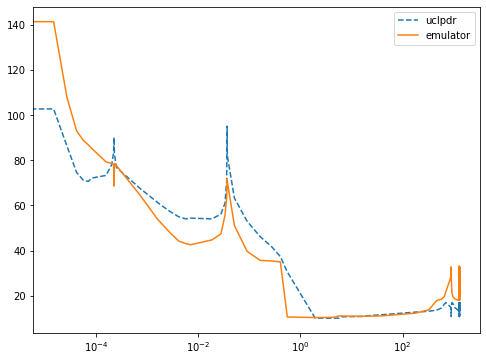

In [167]:
#the first one is the benchmarking of the 'av vs gas temperature'
plt.figure(figsize=(8,6))
plt.plot(uclpdr['Av'],uclpdr['T_g'],label='uclpdr',ls='--')
plt.plot(uclpdr['Av'],output['gas_temp'],label='emulator')
#Notice that the shape of the 'output' depends on the the shape of 'uclpdr'
#And then, the time steps depend on the 'uclpdr' too
plt.xscale('log')
plt.legend()

In [170]:
#Now we do the same with the abundances.
output.columns

Index(['gas_temp', 'dust_temp', 'H', 'H+', 'H2', 'H2+', 'H3+', 'HE', 'HE+',
       'C+', 'C', 'CH', 'CH+', 'CH2', 'CH2+', 'CH3+', 'CH3', 'CH4+', 'O+',
       'CH4', 'O', 'CH5+', 'OH+', 'OH', 'H2O+', 'H2O', 'H3O+', 'MG', 'MG+',
       'CO+', 'CO', 'HCO+', 'O2', 'O2+', 'E-'],
      dtype='object')

In [326]:
len(uclpdr)

97

In [327]:
len(uclpdr['T_g'])

97

In [190]:
from matplotlib.pyplot import cm

In [328]:
#each point(av, abundance) in the following plot corresponds to the av, abundance of a single particle.

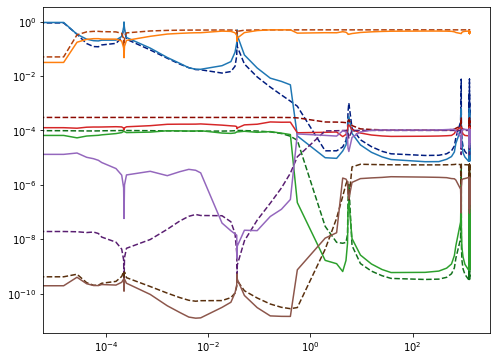

In [217]:
#lets try with the abundances of ["H","H2","C+","O","CO","H2O"]
# the name of the abundances in uclpdr is as follows: {species}_abun
plt.figure(figsize=(8,6))
plt.xscale('log')
plt.yscale('log')
colors=sns.color_palette("dark",n_colors=6)
for k,abun in enumerate(["H","H2","C+","O","CO","H2O"]):
    plt.plot(uclpdr['Av'],uclpdr[f'{abun}_abun'],color=colors[k], ls='--')
    #now the model predictions
    plt.plot(uclpdr['Av'],output[abun])